In [1]:
import scipy as sp
import scipy.sparse
import scipy.sparse.csgraph
import scipy.sparse.linalg
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.rc('font', family='FreeSerif') 
matplotlib.rc('font', serif='regular')

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


markers = ['o','*', 'v', '^', '<', '>', '8', 's', 'p', 'h']

from matplotlib.ticker import FuncFormatter
#ax2.xaxis.set_major_formatter(
#    FuncFormatter(lambda x, p: 
#        '$\mathdefault{10^{%i}}$' % np.log10(x**2)))

/home/hao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  if __name__ == '__main__':


- Generate a disconnected graph W0

In [2]:
# number of points
Ns = [100, 100, 100]
seed = 42

W0s = []
density = 1
for Ni in Ns:
    W0s.append(sp.sparse.random(Ni, Ni, density=density, random_state=seed))
W0 = sp.sparse.block_diag(W0s, format='csr')
W0 += W0.T
W0 /= 2
W0 -= sp.sparse.diags(W0.diagonal())

- Add perturbation and compute eigenvalues and eigenvectors of the graph Laplacian

In [3]:
perturb_level = 3
def get_eigs(eps):    
    W = W0.copy()
    shape = W.shape
    for i in range(perturb_level):
        W += eps * (eps**i) \
         * sp.sparse.random(*shape, density=density, format='csr', 
                           random_state=seed)
    # make sure W is symmetric
    W += W.T
    W /= 2
    # remove diagonals
    W -= sp.sparse.diags(W.diagonal())
    L = sp.sparse.csgraph.laplacian(W, normed=True)
    [w, v] = sp.linalg.eigh(L.toarray())
    return w, v

- Setup others

In [4]:
N = sum(Ns)
K = len(Ns)
num_in_each = 1
D0 = np.asarray(np.sum(W0, axis=1)).flatten()**0.5   # normalization for the 
u = np.zeros((N, K))
fid = np.zeros(N, dtype='int')
Chis = np.zeros((N, K))
idx = 0
for l in range(K):
    fid[idx:idx+num_in_each] = 1
    Chis[idx:idx+Ns[l],l] = D0[idx:idx+Ns[l]]/np.sqrt(Ns[l])
    Chis[idx:idx+Ns[l],l] /= sp.linalg.norm(Chis[idx:idx+Ns[l],l])
    idx += Ns[l]
    

labeled = np.nonzero(fid) 
_, u = get_eigs(0)
u = Chis #@ np.random.randn(K, K)
#u = Chis#.dot(np.random.randn(K, K))
B = sp.sparse.diags(fid, format='csr')


# Fix $\alpha$, plot $\log(\mathcal{I})$ as a heap map over $\gamma$ and $\epsilon$.

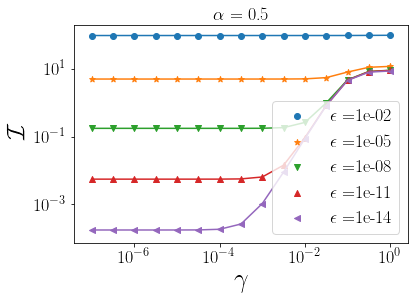

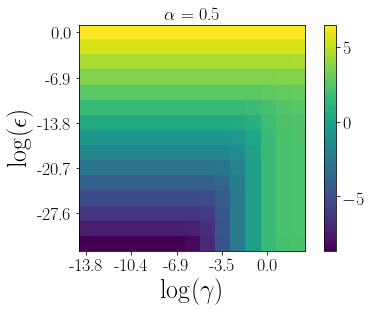

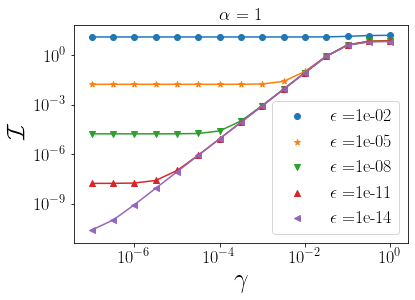

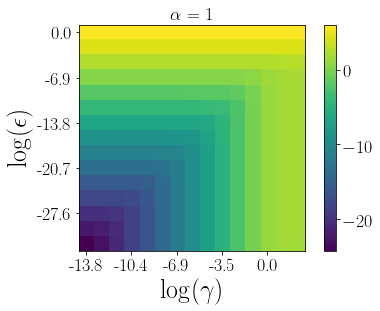

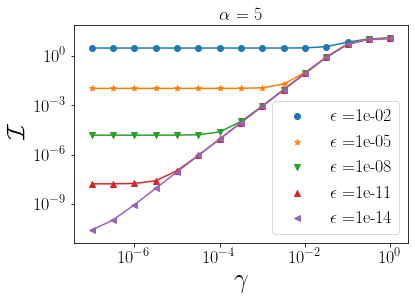

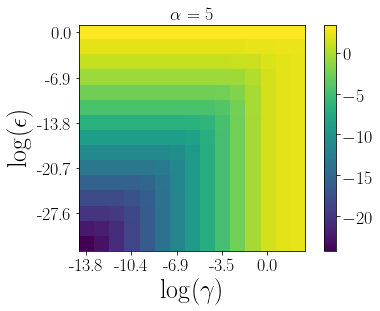

In [8]:
alphas = [0.5, 1, 5]
n_alpha = len(alphas)
n = 15
gammas = np.power(np.sqrt(0.1), range(n))
epss   = np.power(0.1, range(n))

TRC = np.zeros((n, n))
TRCBC = np.zeros((n, n))
BIAS = np.zeros((n, n))
I = np.zeros((n, n))

for ai, alpha in enumerate(alphas):
    fig = plt.figure()
    gax = fig.gca()
    gax.set_xlabel(r'$\gamma$')
    gax.set_ylabel(r'$\mathcal{I}$')
    for i, eps in enumerate(epss):
        w, v = get_eigs(eps)
        tau = (eps) ** (1/max(2, 2 * alpha)) 
        for j, gamma in enumerate(gammas):
            d = (tau ** (2 * alpha)) * np.power(w + tau**2., -alpha)
            d_inv = 1./d  
            prior_inv = v @ sp.sparse.diags(d_inv, format='csr') @ v.T
            # B/gamma^2
            B_over_gamma2 = B / (gamma * gamma)
            # post_inv  : (B/gamma^2 + C_{tau,\eps}^{-1})^{-1}
            post_inv  = prior_inv + B_over_gamma2
            # C^{-1}
            post = post_inv.I
            bias = sp.linalg.norm(post @ B_over_gamma2 @ u - u, ord='fro')

            #bias = sp.linalg.norm(post @ prior_inv @ u, ord='fro')
            BIAS[i,j] = bias ** 2

            trC = sp.trace(post)
            TRC[i,j] = trC

            post2 = post.dot(post)
            trCBC = sp.trace(post2[np.ix_(labeled[0], labeled[0])])
            TRCBC[i, j] = trCBC/(gamma**2.)

            I[i, j] = K * trC + K * trCBC + bias ** 2
            
    stride = 5
    plt.figure()
    plt.imshow(np.flip(np.log(I), 1), cmap=plt.get_cmap('viridis'))
    plt.tight_layout()
    ax = plt.gca()
    plt.colorbar()
    ax.set_xticks(range(0, n, n//stride))
    ax.set_yticks(range(0, n, n//stride))
    ax.set_xticklabels(np.flip(['%.1f'%x for x in np.log(gammas[0:n:n//stride])]))
    ax.set_yticklabels(['%.1f'%x for x in np.log(epss[0:n:n//stride])])
    plt.title(r'$\alpha$ = {}'.format(alpha))
    plt.xlabel(r'$\log(\gamma)$')
    plt.ylabel(r'$\log(\epsilon)$')
    
    mi = 0
    for i, eps in enumerate(epss):
        if i % 3 != 2:
            continue
        target = I[i, :]
        gax.loglog(gammas, target.T)
        gax.scatter(gammas, target, marker = markers[mi], label=r'$\epsilon = $%2.0e'% eps)
        mi += 1
    gax.set_title(r'$\alpha$ = {}'.format(alpha))
    gax.legend()
    fig.savefig('/home/hao/Dropbox/working-directory/uncertainty-quantification/figures/I_vs_gamma_alpha_{}.pdf'.format(alpha),
                bbox_inches="tight")

# $\tau^2 = \epsilon, \gamma = \tau^\alpha$? In this case, $\mathcal{I} = O(\tau^{2\alpha} + \tau^4) = O(\epsilon^\alpha + \epsilon^2)$ according to the Corollary 3.10, which does not correspond to $\tau = o(\sqrt{\epsilon})$.

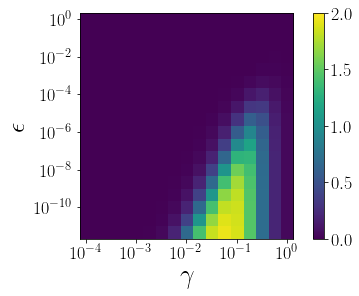

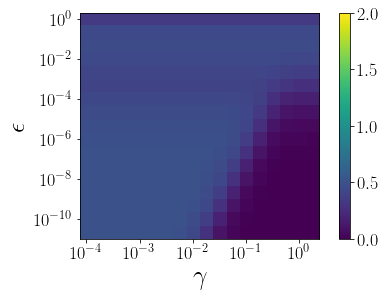

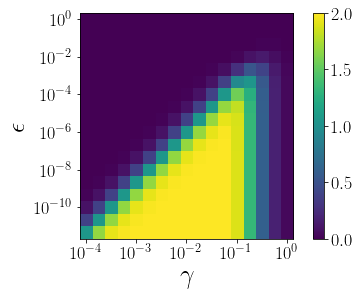

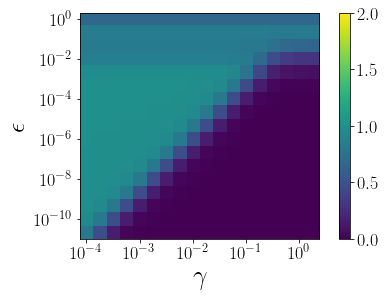

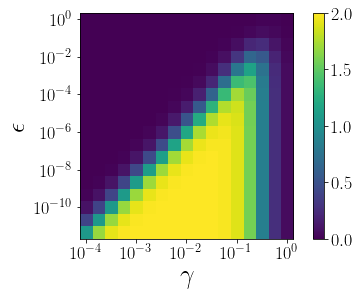

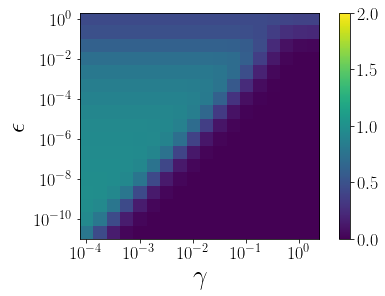

In [12]:
alphas = [0.5, 1, 5]
n_alpha = len(alphas)
n = 18
gammas = np.power(np.sqrt(0.2), range(n))
epss   = np.power(0.2, range(n))

TRC = np.zeros((n, n))
TRCBC = np.zeros((n, n))
BIAS = np.zeros((n, n))
I = np.zeros((n, n))

for ai, alpha in enumerate(alphas):
    for i, eps in enumerate(epss):
        w, v = get_eigs(eps)
        tau = (eps) ** (1/max(2, 2 * alpha)) 
        for j, gamma in enumerate(gammas):
            d = (tau ** (2 * alpha)) * np.power(w + tau**2., -alpha)
            d_inv = 1./d  
            prior_inv = v @ sp.sparse.diags(d_inv, format='csr') @ v.T
            # B/gamma^2
            B_over_gamma2 = B / (gamma * gamma)
            # post_inv  : (B/gamma^2 + C_{tau,\eps}^{-1})^{-1}
            post_inv  = prior_inv + B_over_gamma2
            # C^{-1}
            post = post_inv.I
            bias = sp.linalg.norm(post @ B_over_gamma2 @ u - u, ord='fro')

            #bias = sp.linalg.norm(post @ prior_inv @ u, ord='fro')
            BIAS[i,j] = bias ** 2

            trC = sp.trace(post)
            TRC[i,j] = trC

            post2 = post.dot(post)
            trCBC = sp.trace(post2[np.ix_(labeled[0], labeled[0])])
            TRCBC[i, j] = trCBC/(gamma**2.)

            I[i, j] = K * trC + K * trCBC + bias ** 2
            
    stride = 5
    fig = plt.figure()
    target = np.diff(np.log(I)) / np.diff(np.log(gammas))
    plt.imshow(np.flip(target, axis=1), cmap=plt.get_cmap('viridis'))
    plt.tight_layout()
    ax = plt.gca()
    plt.colorbar()
    plt.clim(0,2)
    ax.set_xticks(range(n-2, -1, -n//stride))
    ax.set_yticks(range(0, n-1, n//stride))
    ax.set_xticklabels([r'$10^{%i}$' % np.log10(x) for x in gammas[0:n:n//stride]])
    ax.set_yticklabels([r'$10^{%i}$' % np.log10(x) for x in epss[0:n:n//stride]])
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$\epsilon$') 
    #plt.title(r'$\frac{\partial \log(\mathcal{I})}{\partial \log(\gamma)}$ with $\alpha$ = %2.1f'% alpha)
    fig.savefig('/home/hao/Dropbox/working-directory/uncertainty-quantification/figures/dI_dgamma_alpha_{}.pdf'.format(alpha),
                bbox_inches="tight")
    # dI / d eps
    fig = plt.figure()
    target = np.diff(np.log(I), axis=0) / np.diff(np.log(epss)).reshape((-1,1))
    plt.imshow(np.flip(target, axis=1), cmap=plt.get_cmap('viridis'))
    plt.tight_layout()
    ax = plt.gca()
    plt.colorbar()
    plt.clim(0, 2)
    ax.set_xticks(range(n-2, -1, -n//stride))
    ax.set_yticks(range(0, n-1, n//stride))
    ax.set_xticklabels([r'$10^{%i}$' % np.log10(x) for x in gammas[0:n:n//stride]])
    ax.set_yticklabels([r'$10^{%i}$' % np.log10(x) for x in epss[0:n:n//stride]])
    
    #plt.title(r'$\frac{\partial \log(\mathcal{I})}{\partial \log(\epsilon)}$ with $\alpha$ = %2.1f'% alpha)
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$\epsilon$')
    fig.savefig('/home/hao/Dropbox/working-directory/uncertainty-quantification/figures/dI_deps_alpha_{}.pdf'.format(alpha),
                bbox_inches="tight")
    

# Disconnected Graph

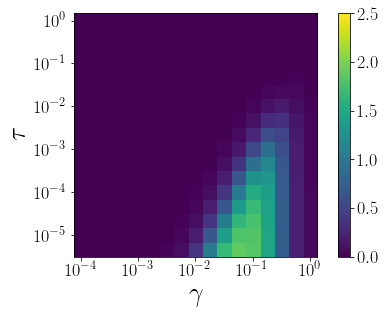

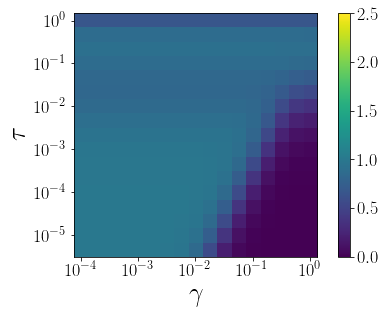

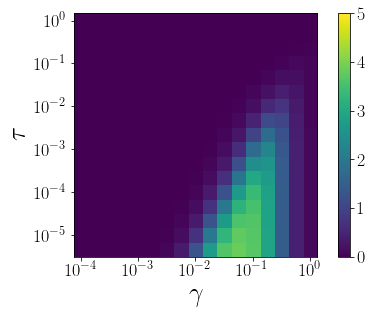

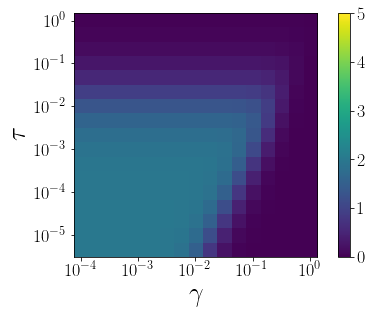

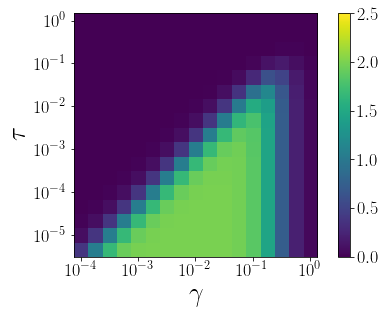

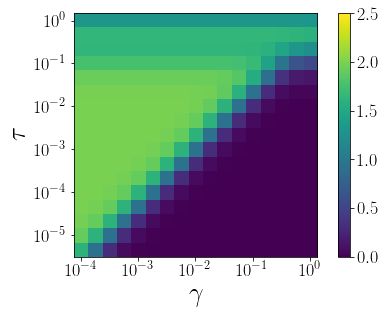

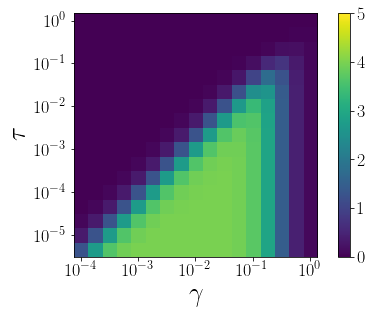

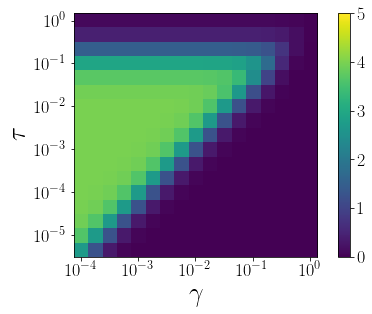

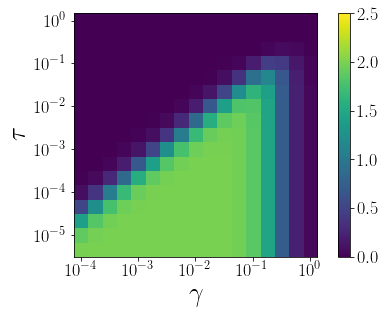

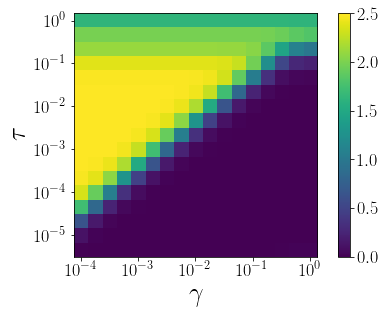

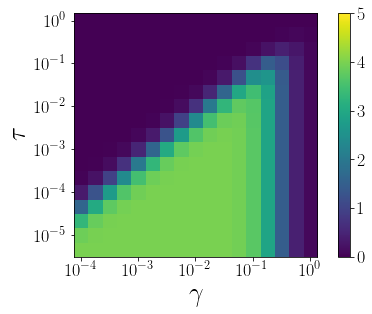

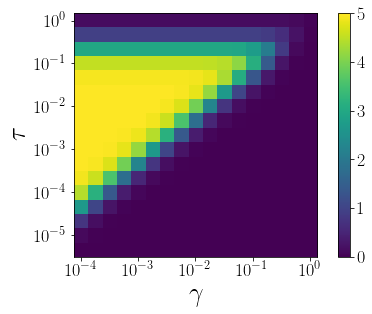

In [11]:
alphas = [0.5, 1, 1.25]
n_alpha = len(alphas)
n = 18
gammas = np.power(np.sqrt(0.2), range(n))
taus   = np.power(np.sqrt(0.2), range(n))

TRC = np.zeros((n, n))
TRCBC = np.zeros((n, n))
BIAS = np.zeros((n, n))
I = np.zeros((n, n))
w, v = get_eigs(0)
w[:3] = 0
for ai, alpha in enumerate(alphas):
    for i, tau in enumerate(taus):
        for j, gamma in enumerate(gammas):
            d = (tau ** (2 * alpha)) * np.power(w + tau**2., -alpha)
            d_inv = 1./d  
            prior_inv = v @ sp.sparse.diags(d_inv, format='csr') @ v.T
            # B/gamma^2
            B_over_gamma2 = B / (gamma * gamma)
            # post_inv  : (B/gamma^2 + C_{tau,\eps}^{-1})^{-1}
            post_inv  = prior_inv + B_over_gamma2
            # C^{-1}
            post = post_inv.I
            bias = sp.linalg.norm(post @ B_over_gamma2 @ u - u, ord='fro')

            #bias = sp.linalg.norm(post @ prior_inv @ u, ord='fro')
            BIAS[i,j] = bias ** 2
            
            trC = max(1e-32, sp.trace(post))
            TRC[i,j] = trC

            post2 = post.dot(post)
            trCBC = sp.trace(post2[np.ix_(labeled[0], labeled[0])])
            TRCBC[i, j] = trCBC/(gamma**2.)

            I[i, j] = K * trC + K * trCBC + bias ** 2
            
    stride = 5
    fig = plt.figure()
    target = np.diff(np.log(TRC)) / np.diff(np.log(gammas))
    target = target[:-1, :]
    plt.imshow(np.flip(target, axis=1), cmap=plt.get_cmap('viridis'))
    plt.tight_layout()
    ax = plt.gca()
    plt.colorbar()
    plt.clim(0,2.5)
    ax.set_xticks(range(n-2, -1, -n//stride))
    ax.set_yticks(range(0, n-1, n//stride))
    ax.set_xticklabels([r'$10^{%i}$' % np.log10(x) for x in gammas[0:n:n//stride]])
    ax.set_yticklabels([r'$10^{%i}$' % np.log10(x) for x in taus[0:n:n//stride]])
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$\tau$') 
    #plt.title(r'$\alpha$ = %2.2f'% alpha)
    fig.savefig('/home/hao/Dropbox/working-directory/uncertainty-quantification/figures/dtrc_dgamma_alpha_{}.pdf'.format(alpha),
                bbox_inches="tight")
    # dI / d eps
    fig = plt.figure()  
    target = np.diff(np.log(TRC), axis=0) / np.diff(np.log(taus)).reshape((-1,1)) 
    target = target[:, 1:]
    plt.imshow(np.flip(target, axis=1), cmap=plt.get_cmap('viridis'))
    plt.tight_layout()
    ax = plt.gca()
    plt.colorbar()
    plt.clim(0, 2.5)
    ax.set_xticks(range(n-2, -1, -n//stride))
    ax.set_yticks(range(0, n-1, n//stride))
    ax.set_xticklabels([r'$10^{%i}$' % np.log10(x) for x in gammas[0:n:n//stride]])
    ax.set_yticklabels([r'$10^{%i}$' % np.log10(x) for x in taus[0:n:n//stride]])
    
    #plt.title(r'$\alpha$ = %2.2f'% alpha)
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$\tau$')
    fig.savefig('/home/hao/Dropbox/working-directory/uncertainty-quantification/figures/dtrc_dtau_alpha_{}.pdf'.format(alpha),
                bbox_inches="tight")
    
    
    # Bias
    fig = plt.figure()
    target = np.diff(np.log(BIAS)) / np.diff(np.log(gammas))
    target = target[:-1, :]
    plt.imshow(np.flip(target, axis=1), cmap=plt.get_cmap('viridis'))
    plt.tight_layout()
    ax = plt.gca()
    plt.colorbar()
    plt.clim(0,5)
    ax.set_xticks(range(n-2, -1, -n//stride))
    ax.set_yticks(range(0, n-1, n//stride))
    ax.set_xticklabels([r'$10^{%i}$' % np.log10(x) for x in gammas[0:n:n//stride]])
    ax.set_yticklabels([r'$10^{%i}$' % np.log10(x) for x in taus[0:n:n//stride]])
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$\tau$') 
    #plt.title(r'$\alpha$ = %2.2f'% alpha)
    fig.savefig('/home/hao/Dropbox/working-directory/uncertainty-quantification/figures/dbias_dgamma_alpha_{}.pdf'.format(alpha),
                bbox_inches="tight")
    # dI / d eps
    fig = plt.figure()  
    target = np.diff(np.log(BIAS), axis=0) / np.diff(np.log(taus)).reshape((-1,1)) 
    target = target[:, 1:]
    plt.imshow(np.flip(target, axis=1), cmap=plt.get_cmap('viridis'))
    plt.tight_layout()
    ax = plt.gca()
    plt.colorbar()
    plt.clim(0, 5)
    ax.set_xticks(range(n-2, -1, -n//stride))
    ax.set_yticks(range(0, n-1, n//stride))
    ax.set_xticklabels([r'$10^{%i}$' % np.log10(x) for x in gammas[0:n:n//stride]])
    ax.set_yticklabels([r'$10^{%i}$' % np.log10(x) for x in taus[0:n:n//stride]])
    
    #plt.title(r'$\alpha$ = %2.2f'% alpha)
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$\tau$')
    fig.savefig('/home/hao/Dropbox/working-directory/uncertainty-quantification/figures/dbias_dtau_alpha_{}.pdf'.format(alpha),
                bbox_inches="tight")
    
    

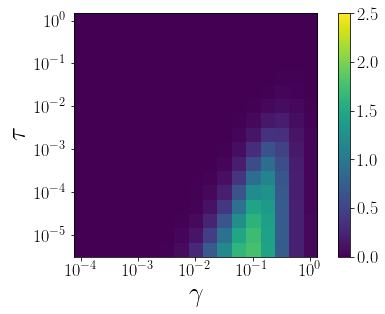

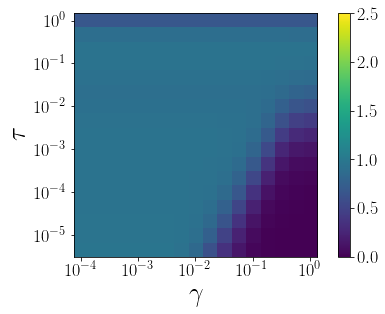

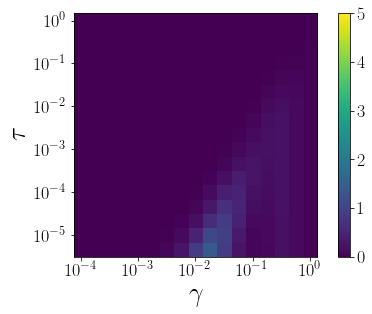

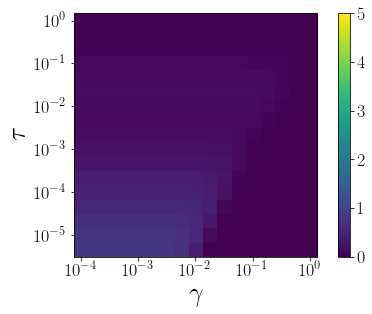

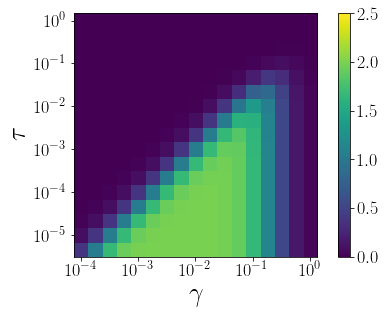

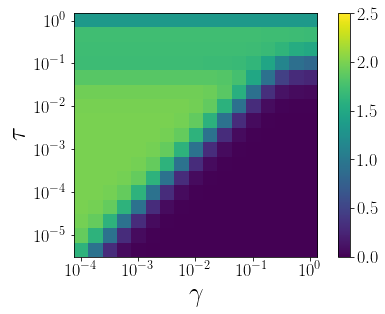

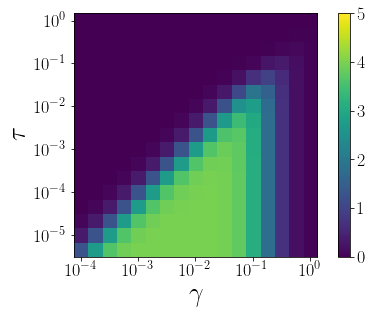

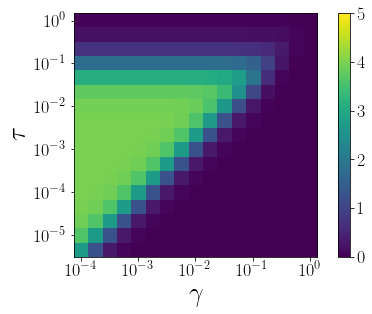

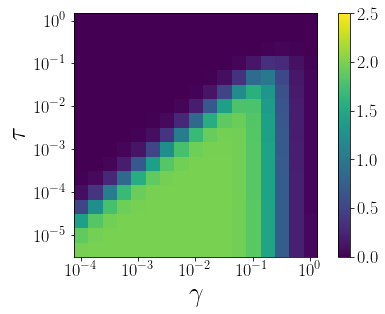

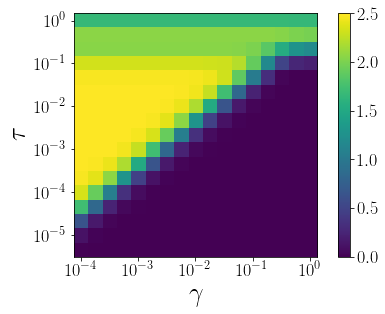

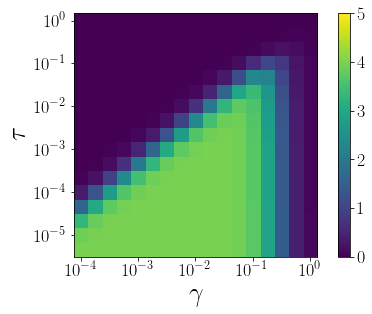

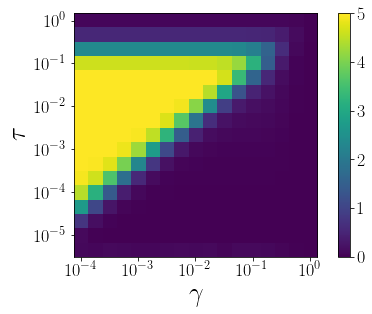

In [13]:
alphas = [0.5, 1, 1.25]
n_alpha = len(alphas)
n = 18
gammas = np.power(np.sqrt(0.2), range(n))
taus   = np.power(np.sqrt(0.2), range(n))

TRC = np.zeros((n, n))
TRCBC = np.zeros((n, n))
BIAS = np.zeros((n, n))
I = np.zeros((n, n))
w, v = get_eigs(0)
w[:3] = 0


for ai, alpha in enumerate(alphas):
    for i, tau in enumerate(taus):
        #eps = tau ** (max(2, 2 * alpha))
        eps = tau ** (2 * alpha)
        w, v = get_eigs(eps)
        for j, gamma in enumerate(gammas):
            d = (tau ** (2 * alpha)) * np.power(w + tau**2., -alpha)
            d_inv = 1./d  
            prior_inv = v @ sp.sparse.diags(d_inv, format='csr') @ v.T
            # B/gamma^2
            B_over_gamma2 = B / (gamma * gamma)
            # post_inv  : (B/gamma^2 + C_{tau,\eps}^{-1})^{-1}
            post_inv  = prior_inv + B_over_gamma2
            # C^{-1}
            post = post_inv.I
            bias = sp.linalg.norm(post @ B_over_gamma2 @ u - u, ord='fro')

            #bias = sp.linalg.norm(post @ prior_inv @ u, ord='fro')
            BIAS[i,j] = bias ** 2
            
            trC = max(1e-32, sp.trace(post))
            TRC[i,j] = trC

            post2 = post.dot(post)
            trCBC = sp.trace(post2[np.ix_(labeled[0], labeled[0])])
            TRCBC[i, j] = trCBC/(gamma**2.)

            I[i, j] = K * trC + K * trCBC + bias ** 2
            
    stride = 5
    fig = plt.figure()
    target = np.diff(np.log(TRC)) / np.diff(np.log(gammas))
    target = target[:-1, :]
    plt.imshow(np.flip(target, axis=1), cmap=plt.get_cmap('viridis'))
    plt.tight_layout()
    ax = plt.gca()
    plt.colorbar()
    plt.clim(0,2.5)
    ax.set_xticks(range(n-2, -1, -n//stride))
    ax.set_yticks(range(0, n-1, n//stride))
    ax.set_xticklabels([r'$10^{%i}$' % np.log10(x) for x in gammas[0:n:n//stride]])
    ax.set_yticklabels([r'$10^{%i}$' % np.log10(x) for x in taus[0:n:n//stride]])
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$\tau$') 
    #plt.title(r'$\alpha$ = %2.2f'% alpha)
    fig.savefig('/home/hao/Dropbox/working-directory/uncertainty-quantification/figures/dtrc_connected_dgamma_alpha_{}.pdf'.format(alpha),
                bbox_inches="tight")
    # dI / d eps
    fig = plt.figure()  
    target = np.diff(np.log(TRC), axis=0) / np.diff(np.log(taus)).reshape((-1,1)) 
    target = target[:, 1:]
    plt.imshow(np.flip(target, axis=1), cmap=plt.get_cmap('viridis'))
    plt.tight_layout()
    ax = plt.gca()
    plt.colorbar()
    plt.clim(0, 2.5)
    ax.set_xticks(range(n-2, -1, -n//stride))
    ax.set_yticks(range(0, n-1, n//stride))
    ax.set_xticklabels([r'$10^{%i}$' % np.log10(x) for x in gammas[0:n:n//stride]])
    ax.set_yticklabels([r'$10^{%i}$' % np.log10(x) for x in taus[0:n:n//stride]])
    
    #plt.title(r'$\alpha$ = %2.2f'% alpha)
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$\tau$')
    fig.savefig('/home/hao/Dropbox/working-directory/uncertainty-quantification/figures/dtrc_connected_dtau_alpha_{}.pdf'.format(alpha),
                bbox_inches="tight")
    
    
    # Bias
    fig = plt.figure()
    target = np.diff(np.log(BIAS)) / np.diff(np.log(gammas))
    target = target[:-1, :]
    plt.imshow(np.flip(target, axis=1), cmap=plt.get_cmap('viridis'))
    plt.tight_layout()
    ax = plt.gca()
    plt.colorbar()
    plt.clim(0,5)
    ax.set_xticks(range(n-2, -1, -n//stride))
    ax.set_yticks(range(0, n-1, n//stride))
    ax.set_xticklabels([r'$10^{%i}$' % np.log10(x) for x in gammas[0:n:n//stride]])
    ax.set_yticklabels([r'$10^{%i}$' % np.log10(x) for x in taus[0:n:n//stride]])
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$\tau$') 
    #plt.title(r'$\alpha$ = %2.2f'% alpha)
    fig.savefig('/home/hao/Dropbox/working-directory/uncertainty-quantification/figures/dbias_connected_dgamma_alpha_{}.pdf'.format(alpha),
                bbox_inches="tight")
    # dI / d eps
    fig = plt.figure()  
    target = np.diff(np.log(BIAS), axis=0) / np.diff(np.log(taus)).reshape((-1,1)) 
    target = target[:, 1:]
    plt.imshow(np.flip(target, axis=1), cmap=plt.get_cmap('viridis'))
    plt.tight_layout()
    ax = plt.gca()
    plt.colorbar()
    plt.clim(0, 5)
    ax.set_xticks(range(n-2, -1, -n//stride))
    ax.set_yticks(range(0, n-1, n//stride))
    ax.set_xticklabels([r'$10^{%i}$' % np.log10(x) for x in gammas[0:n:n//stride]])
    ax.set_yticklabels([r'$10^{%i}$' % np.log10(x) for x in taus[0:n:n//stride]])
    
    #plt.title(r'$\alpha$ = %2.2f'% alpha)
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$\tau$')
    fig.savefig('/home/hao/Dropbox/working-directory/uncertainty-quantification/figures/dbias_connected_dtau_alpha_{}.pdf'.format(alpha),
                bbox_inches="tight")
    
    